In [14]:
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectKBest, chi2
from imblearn.under_sampling import RandomUnderSampler

In [15]:
df = pd.read_csv('./Focos_2020-01-01_2020-12-31.csv')
print(f'Tamanho da Base de Dados: \n\n Linhas: {df.shape[0]},  Colunas; {df.shape[1]}\n')
df.tail()


Tamanho da Base de Dados: 

 Linhas: 222797,  Colunas; 12



,datahora,satelite,pais,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
222792,2020/07/11 16:50:00,AQUA_M-T,Brasil,PARA,PARAGOMINAS,Amazonia,10.0,0.0,0.3,-3.183,-47.246,12.7
222793,2020/07/11 16:45:00,AQUA_M-T,Brasil,RIO DE JANEIRO,RIO DE JANEIRO,Mata Atlantica,10.0,0.0,0.8,-22.855,-43.508,11.1
222794,2020/07/11 16:45:00,AQUA_M-T,Brasil,MINAS GERAIS,FORMIGA,Cerrado,11.0,0.2,0.8,-20.542,-45.689,11.2
222795,2020/07/11 16:50:00,AQUA_M-T,Brasil,PARA,TOME-ACU,Amazonia,10.0,1.8,0.1,-2.840,-48.110,19.5
222796,2020/07/11 16:50:00,AQUA_M-T,Brasil,PARA,PORTEL,Amazonia,2.0,1.6,0.1,-2.371,-50.491,5.7


### Tratamento dos dados

In [16]:
# Remove os Registros Duplicados.
dfClean = df.drop_duplicates(keep=False).copy()

# Remove os Atributos Irrelevantes do DataFrame.
dfClean.drop(['pais', 'municipio', 'latitude', 'longitude', 'satelite'], inplace=True, axis=1)

# Valor Padrão Definido Para o Atributo Dias Sem Chuva - (diasemchuva).
median = dfClean['diasemchuva'].median()

# Tratando Valores NAN/NULL.
dfClean['diasemchuva'].fillna(median, inplace=True)

# Tratando Valores Menores que Zero.
dfClean['diasemchuva'] = dfClean['diasemchuva'].apply(lambda item: 0.0 if item < 0 else item)

print('Informações do Atributo Dias Sem Chuva:\n')

# Tratando Valores Menores que Zero.
dfClean['diasemchuva'] = dfClean['diasemchuva'].apply(lambda item: 0.0 if item < 0 else item)

dfClean['precipitacao'].fillna(median, inplace=True)

# Tratando Valores Menores que Zero.
dfClean['precipitacao'] = dfClean['precipitacao'].apply(lambda item: 0.0 if item < 0 else item)

# Tratando Valores Maiores que Duzentos.
dfClean['precipitacao'] = dfClean['precipitacao'].apply(lambda item: 200.0 if item > 200 else item)


# Valor Padrão Definido Para o Atributo Risco De Fogo - (riscofogo).

median = dfClean['riscofogo'].median()
medians = dfClean.groupby('bioma')['riscofogo'].median()

# Tratando Valores NAN/NULL.
for i in dfClean.index:

    if pd.isnull(dfClean.at[i, 'riscofogo']):

        biome = dfClean.at[i, 'bioma']
        
        dfClean.at[i, 'riscofogo'] = median if pd.isnull(biome) else medians[biome]

# Tratando Valores Menores que Zero.
dfClean['riscofogo'] = dfClean['riscofogo'].apply(lambda item: 0.0 if item < 0 else item)



# Valor Padrão Definido Para o Atributo Fire Radiative Power - (frp).
median = dfClean['frp'].median()

# Tratando Valores NAN/NULL.
dfClean['frp'].fillna(median, inplace=True)

# Tratando Valores Menores que Zero.
dfClean['frp'] = dfClean['frp'].apply(lambda item: 0.0 if item < 0 else item)

# Tratando Valores Maiores que Oito Mil.
dfClean['frp'] = dfClean['frp'].apply(lambda item: 8000.0 if item > 8000 else item)


# Criando Um Novo Atributo Mes - (mes) a Partir Do Atributo Data e Hora - (datahora) Para o DataFrame.

# Separando o Mes Da Data e Hora do Atributo Data e Hora - (datahora).
dfClean['datahora'] = pd.DatetimeIndex(dfClean['datahora']).month

# Renomeando o Atributo Data e Hora - (datahora) Para Mes - (mes).
dfClean.rename(columns={'datahora':'mes'}, inplace=True)

dfClean.head()

Informações do Atributo Dias Sem Chuva:



,mes,estado,bioma,diasemchuva,precipitacao,riscofogo,frp
0,7,GOIAS,Cerrado,43.0,0.0,1.0,11.0
1,7,GOIAS,Cerrado,42.0,0.0,0.9,9.5
2,7,RIO DE JANEIRO,Mata Atlantica,38.0,0.0,0.8,13.0
3,7,MINAS GERAIS,Caatinga,46.0,0.0,1.0,17.6
4,7,PARA,Amazonia,0.0,0.4,0.2,18.7


### Normalizar atributos quantitativos.

In [17]:
# Normalizando  Atributo Dias Sem Chuva - (diasemchuva).

# Separando os Valores Limites.
max = dfClean['diasemchuva'].max()
min = dfClean['diasemchuva'].min()

# Aplicando a Normalização ao Atributo Dias Sem Chuva - (diasemchuva).
dfClean['diasemchuva'] = dfClean['diasemchuva'].apply(lambda item: (item - min) / (max - min))

# Exibindo os Valores Limites do Atributo Dias Sem Chuva - (diasemchuva).

print('Informações do Atributo Dias Sem Chuva:\n')

print(f'Valor Máximo: {max}')
print(f'Valor Miníno: {min}\n')

dfClean

Informações do Atributo Dias Sem Chuva:

Valor Máximo: 120.0
Valor Miníno: 0.0



,mes,estado,bioma,diasemchuva,precipitacao,riscofogo,frp
0,7,GOIAS,Cerrado,0.358333,0.0,1.0,11.0
1,7,GOIAS,Cerrado,0.350000,0.0,0.9,9.5
2,7,RIO DE JANEIRO,Mata Atlantica,0.316667,0.0,0.8,13.0
3,7,MINAS GERAIS,Caatinga,0.383333,0.0,1.0,17.6
4,7,PARA,Amazonia,0.000000,0.4,0.2,18.7
...,...,...,...,...,...,...,...
222792,7,PARA,Amazonia,0.083333,0.0,0.3,12.7
222793,7,RIO DE JANEIRO,Mata Atlantica,0.083333,0.0,0.8,11.1
222794,7,MINAS GERAIS,Cerrado,0.091667,0.2,0.8,11.2
222795,7,PARA,Amazonia,0.083333,1.8,0.1,19.5


In [18]:
# Normalizando  Atributo Precipitação - (precipitacao).

max = dfClean['precipitacao'].max()
min = dfClean['precipitacao'].min()

dfClean['precipitacao'] = dfClean['precipitacao'].apply(lambda item: (item - min) / (max - min))

# Exibindo os Valores Limites do Atributo Precipitação - (precipitacao).

print('Informações do Atributo Precipitação:\n')

print(f'Valor Máximo: {max}')
print(f'Valor Miníno: {min}\n')

dfClean

Informações do Atributo Precipitação:

Valor Máximo: 125.5
Valor Miníno: 0.0



,mes,estado,bioma,diasemchuva,precipitacao,riscofogo,frp
0,7,GOIAS,Cerrado,0.358333,0.000000,1.0,11.0
1,7,GOIAS,Cerrado,0.350000,0.000000,0.9,9.5
2,7,RIO DE JANEIRO,Mata Atlantica,0.316667,0.000000,0.8,13.0
3,7,MINAS GERAIS,Caatinga,0.383333,0.000000,1.0,17.6
4,7,PARA,Amazonia,0.000000,0.003187,0.2,18.7
...,...,...,...,...,...,...,...
222792,7,PARA,Amazonia,0.083333,0.000000,0.3,12.7
222793,7,RIO DE JANEIRO,Mata Atlantica,0.083333,0.000000,0.8,11.1
222794,7,MINAS GERAIS,Cerrado,0.091667,0.001594,0.8,11.2
222795,7,PARA,Amazonia,0.083333,0.014343,0.1,19.5


In [19]:
# Normalizando  Atributo Fire Radiative Power - (frp).

max = dfClean['frp'].max()
min = dfClean['frp'].min()

dfClean['frp'] = dfClean['frp'].apply(lambda item: (item - min) / (max - min))

# Exibindo os Valores Limites do Atributo Fire Radiative Power - (frp).

print('Informações do Atributo Fire Radiative Power:\n')

print(f'Valor Máximo: {max}')
print(f'Valor Miníno: {min}\n')

dfClean

Informações do Atributo Fire Radiative Power:

Valor Máximo: 8000.0
Valor Miníno: 0.0



,mes,estado,bioma,diasemchuva,precipitacao,riscofogo,frp
0,7,GOIAS,Cerrado,0.358333,0.000000,1.0,0.001375
1,7,GOIAS,Cerrado,0.350000,0.000000,0.9,0.001187
2,7,RIO DE JANEIRO,Mata Atlantica,0.316667,0.000000,0.8,0.001625
3,7,MINAS GERAIS,Caatinga,0.383333,0.000000,1.0,0.002200
4,7,PARA,Amazonia,0.000000,0.003187,0.2,0.002337
...,...,...,...,...,...,...,...
222792,7,PARA,Amazonia,0.083333,0.000000,0.3,0.001587
222793,7,RIO DE JANEIRO,Mata Atlantica,0.083333,0.000000,0.8,0.001388
222794,7,MINAS GERAIS,Cerrado,0.091667,0.001594,0.8,0.001400
222795,7,PARA,Amazonia,0.083333,0.014343,0.1,0.002437


### 7 - Transformar atributos qualitativos em quantitativos (dummies).

In [20]:
# Transformando os Atributos Qualitativos em Atributos Quantitativos.

dfClean = pd.get_dummies(dfClean, columns=['estado', 'bioma'], prefix=['E', 'B'])

dfClean

,mes,diasemchuva,precipitacao,riscofogo,frp,E_ACRE,E_ALAGOAS,E_AMAPA,E_AMAZONAS,E_BAHIA,...,E_SANTA CATARINA,E_SAO PAULO,E_SERGIPE,E_TOCANTINS,B_Amazonia,B_Caatinga,B_Cerrado,B_Mata Atlantica,B_Pampa,B_Pantanal
0,7,0.358333,0.000000,1.0,0.001375,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,7,0.350000,0.000000,0.9,0.001187,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,7,0.316667,0.000000,0.8,0.001625,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,7,0.383333,0.000000,1.0,0.002200,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,7,0.000000,0.003187,0.2,0.002337,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222792,7,0.083333,0.000000,0.3,0.001587,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
222793,7,0.083333,0.000000,0.8,0.001388,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
222794,7,0.091667,0.001594,0.8,0.001400,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
222795,7,0.083333,0.014343,0.1,0.002437,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [37]:
X = dfClean.drop(columns = ['riscofogo']) # pegando o db sem a variável resposta
# Binarização da variável resposta
threshold = 0.5
y = np.where(dfClean['riscofogo'] > threshold, 1, 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=2023)

# Tiro uma parte do teste para colocar na validacao
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.40, random_state=2023)

X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)
X_val = np.asarray(X_val).astype(np.float32)
y_val = np.asarray(y_val).astype(np.float32)

print(f" Treino {len(X_train)}, Teste {len(X_test)}, Validacao {len(X_val)}")

 Treino 133678, Teste 53471, Validacao 35648


### Modelo 1: Random Forest

Matriz de Confusão - TREINO:
[[38087   465]
 [  467 94659]]
Acurácia - TREINO: 0.9930
Recall - TREINO: 0.9951
Precisão - TREINO: 0.9951




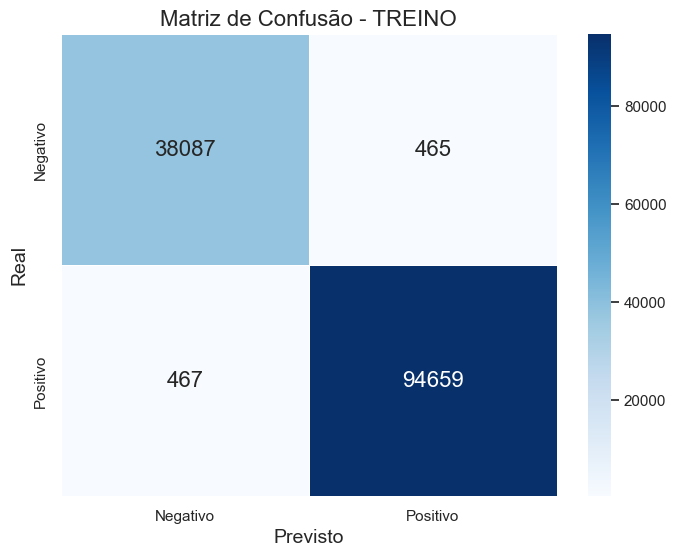

Matriz de Confusão - TESTE:
[[12269  3240]
 [ 3274 34688]]
Acurácia - TESTE: 0.8782
Recall - TESTE: 0.9138
Precisão - TESTE: 0.9146




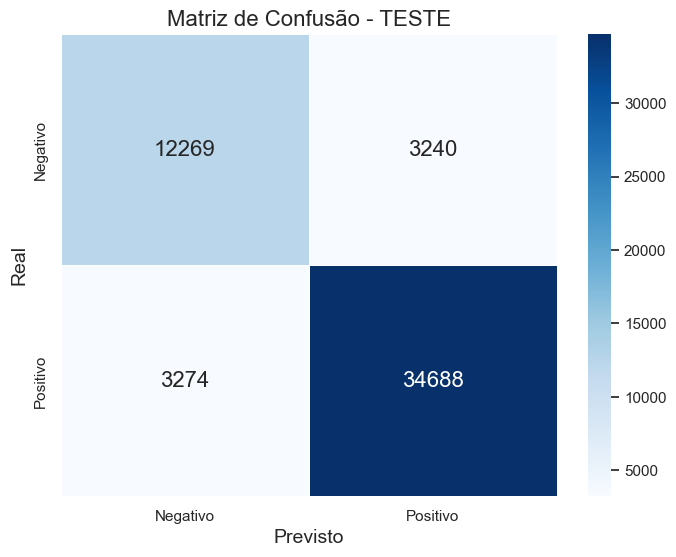

Matriz de Confusão - VALIDAÇÃO:
[[ 7925  2211]
 [ 2246 23266]]
Acurácia - VALIDAÇÃO: 0.8750
Recall - VALIDAÇÃO: 0.9120
Precisão - VALIDAÇÃO: 0.9132




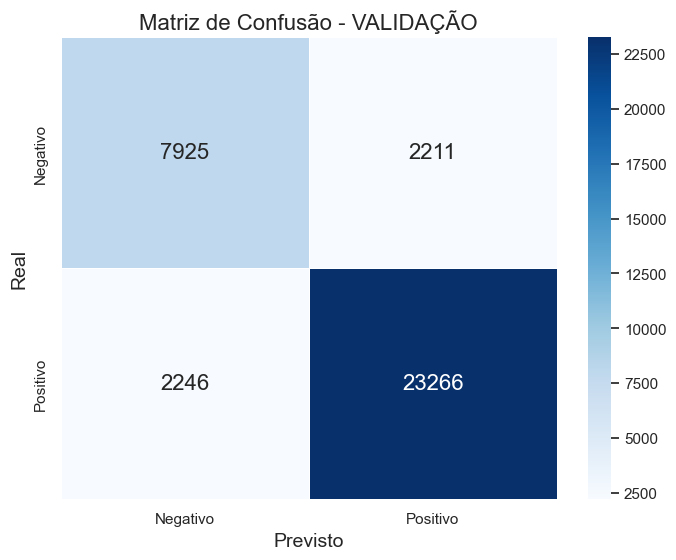

In [38]:
sns.set()

# Criar modelo Random Forest
model_rf = RandomForestClassifier(n_estimators=150, random_state=2023)

# Treinar o modelo
model_rf.fit(X_train, y_train)

# Função para avaliar o modelo e gerar métricas
def evaluate_model_metrics(model, X, y, set_name):
    y_pred = model.predict(X)
    confusion = confusion_matrix(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)

    print(f"Matriz de Confusão - {set_name.upper()}:")
    print(confusion)
    print(f"Acurácia - {set_name.upper()}: {accuracy:.4f}")
    print(f"Recall - {set_name.upper()}: {recall:.4f}")
    print(f"Precisão - {set_name.upper()}: {precision:.4f}")
    print("\n")

    # Plotar a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", linewidths=.5, annot_kws={"size": 16})
    plt.title(f'Matriz de Confusão - {set_name.upper()}', size=16)
    plt.xlabel('Previsto', size=14)
    plt.ylabel('Real', size=14)
    plt.xticks([0.5, 1.5], ['Negativo', 'Positivo'])
    plt.yticks([0.5, 1.5], ['Negativo', 'Positivo'])
    plt.show()

# Avaliação no conjunto de treinamento
evaluate_model_metrics(model_rf, X_train, y_train, "Treino")

# Avaliação no conjunto de teste
evaluate_model_metrics(model_rf, X_test, y_test, "Teste")

# Avaliação no conjunto de validação
evaluate_model_metrics(model_rf, X_val, y_val, "Validação")

### Modelo 2: MLP

In [39]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',            # Métrica a ser monitorada
    patience=50,               # Número de épocas sem melhoria antes de parar o treinamento
    restore_best_weights=True  # Restaura os melhores pesos encontrados durante o treinamento
)

In [40]:
def lr_scheduler(epoch):
    if epoch < 50:
        return 0.005
    elif epoch < 100:
        return 0.001
    elif epoch < 150:
        return 0.0005
    else:
        return 0.0001

# Criando o callback para o Learning Rate Scheduler
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [41]:
def evaluate_model(model, X, y, set_name):
    y_pred = (model.predict(X) > 0.5).astype("int32")
    confusion = confusion_matrix(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)

    print(f"Matriz de Confusão - {set_name.upper()}:")
    print(confusion)
    print(f"Acurácia - {set_name.upper()}: {accuracy:.4f}")
    print(f"Recall - {set_name.upper()}: {recall:.4f}")
    print(f"Precisão - {set_name.upper()}: {precision:.4f}")
    print("\n")

    # Plotar a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", linewidths=.5, annot_kws={"size": 16})
    plt.title(f'Matriz de Confusão - {set_name.upper()}', size=16)
    plt.xlabel('Previsto', size=14)
    plt.ylabel('Real', size=14)
    plt.xticks([0.5, 1.5], ['Negativo', 'Positivo'])
    plt.yticks([0.5, 1.5], ['Negativo', 'Positivo'])
    plt.show()

Epoch 1/1000
5/5 [==============================] - 3s 358ms/step - loss: 0.6727 - accuracy: 0.4992 - val_loss: 0.6018 - val_accuracy: 0.7157 - lr: 0.0050
Epoch 2/1000
5/5 [==============================] - 1s 285ms/step - loss: 0.6104 - accuracy: 0.7116 - val_loss: 0.5965 - val_accuracy: 0.7157 - lr: 0.0050
Epoch 3/1000
5/5 [==============================] - 1s 284ms/step - loss: 0.5974 - accuracy: 0.7116 - val_loss: 0.6098 - val_accuracy: 0.7157 - lr: 0.0050
Epoch 4/1000
5/5 [==============================] - 2s 299ms/step - loss: 0.6123 - accuracy: 0.7116 - val_loss: 0.6349 - val_accuracy: 0.7157 - lr: 0.0050
Epoch 5/1000
5/5 [==============================] - 1s 281ms/step - loss: 0.6438 - accuracy: 0.7116 - val_loss: 0.5889 - val_accuracy: 0.7157 - lr: 0.0050
Epoch 6/1000
5/5 [==============================] - 1s 281ms/step - loss: 0.5569 - accuracy: 0.7133 - val_loss: 0.6437 - val_accuracy: 0.7270 - lr: 0.0050
Epoch 7/1000
5/5 [==============================] - 1s 262ms/step - lo

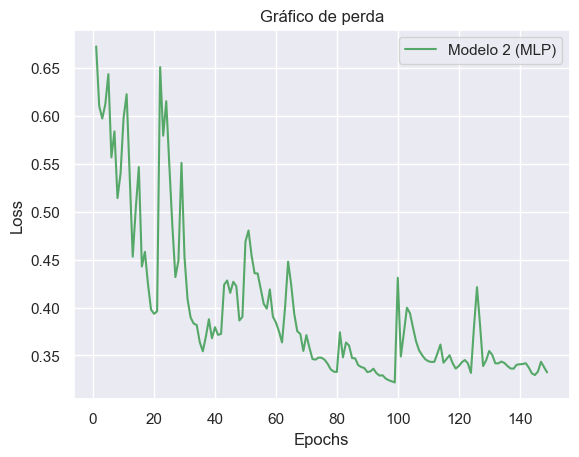

4178/4178 [==============================] - 8s 2ms/step
Matriz de Confusão - TREINO:
[[33039  5513]
 [15837 79289]]
Acurácia - TREINO: 0.8403
Recall - TREINO: 0.8335
Precisão - TREINO: 0.9350




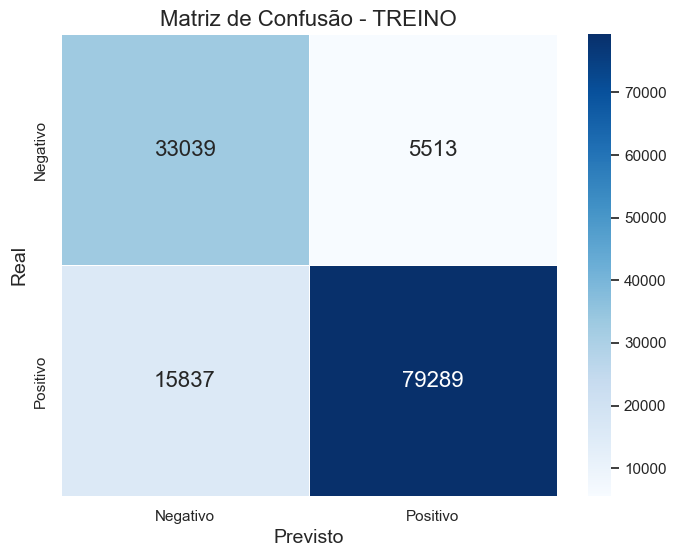

1671/1671 [==============================] - 3s 2ms/step
Matriz de Confusão - TESTE:
[[13336  2173]
 [ 6159 31803]]
Acurácia - TESTE: 0.8442
Recall - TESTE: 0.8378
Precisão - TESTE: 0.9360




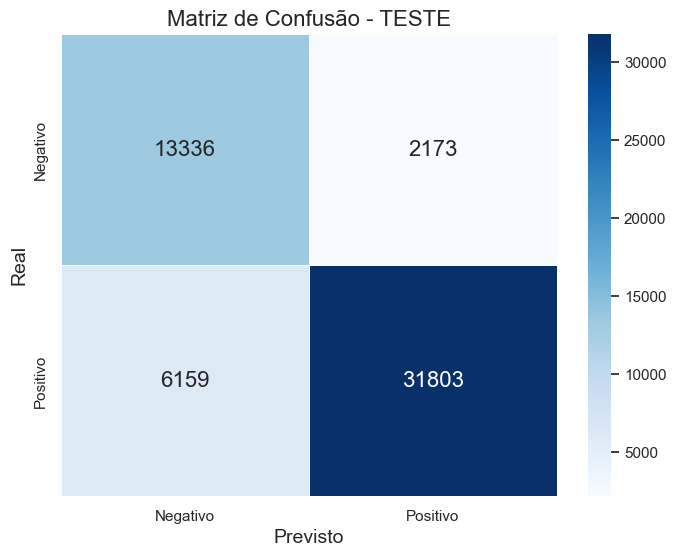

1114/1114 [==============================] - 2s 2ms/step
Matriz de Confusão - VALIDAÇÃO:
[[ 8674  1462]
 [ 4181 21331]]
Acurácia - VALIDAÇÃO: 0.8417
Recall - VALIDAÇÃO: 0.8361
Precisão - VALIDAÇÃO: 0.9359




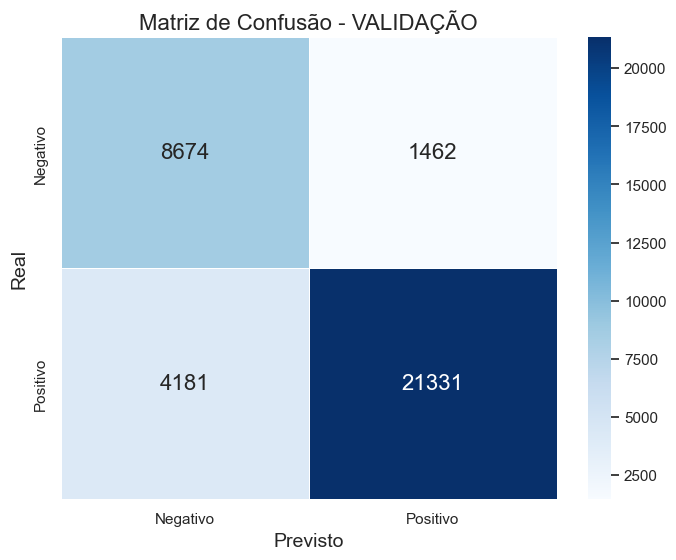

In [42]:
model2 = Sequential()

model2.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))


model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history2 = model2.fit(
    X_train, 
    y_train, 
    epochs=1000, 
    batch_size=int(0.25 * len(X_train)), 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping_callback, lr_scheduler_callback],
    verbose=1
)

# Grafico do Loss
train_loss2 = history2.history['loss']
epochs = range(1, len(train_loss2) + 1)
plt.plot(epochs, train_loss2, 'g', label='Modelo 2 (MLP)')
plt.title('Gráfico de perda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

evaluate_model(model2, X_train, y_train, "Treino")

# Avaliação no conjunto de teste
evaluate_model(model2, X_test, y_test, "Teste")

# Avaliação no conjunto de validação
evaluate_model(model2, X_val, y_val, "Validação")

,mes,diasemchuva,precipitacao,frp,E_ACRE,E_ALAGOAS,E_AMAPA,E_AMAZONAS,E_BAHIA,E_CEARA,...,E_SANTA CATARINA,E_SAO PAULO,E_SERGIPE,E_TOCANTINS,B_Amazonia,B_Caatinga,B_Cerrado,B_Mata Atlantica,B_Pampa,B_Pantanal
129255,9,0.025000,0.000000,0.006250,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
113156,9,0.491667,0.000000,0.004912,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
194074,6,0.150000,0.000000,0.001813,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
105229,9,0.000000,0.014343,0.002812,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
83985,9,0.816667,0.000000,0.006037,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169889,10,0.041667,0.000000,0.005463,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
182967,11,0.100000,0.000000,0.002837,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
178630,11,0.041667,0.000000,0.008587,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
22041,8,0.525000,0.000000,0.002575,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


### Modelo 3: MLP

Epoch 1/1000
5/5 [==============================] - 3s 291ms/step - loss: 0.6818 - accuracy: 0.4961 - val_loss: 0.6018 - val_accuracy: 0.7157 - lr: 0.0050
Epoch 2/1000
5/5 [==============================] - 1s 191ms/step - loss: 0.5992 - accuracy: 0.7116 - val_loss: 0.6105 - val_accuracy: 0.7157 - lr: 0.0050
Epoch 3/1000
5/5 [==============================] - 1s 204ms/step - loss: 0.6080 - accuracy: 0.7116 - val_loss: 0.5654 - val_accuracy: 0.7157 - lr: 0.0050
Epoch 4/1000
5/5 [==============================] - 1s 256ms/step - loss: 0.5896 - accuracy: 0.7116 - val_loss: 0.5697 - val_accuracy: 0.7157 - lr: 0.0050
Epoch 5/1000
5/5 [==============================] - 1s 261ms/step - loss: 0.5598 - accuracy: 0.7116 - val_loss: 0.5308 - val_accuracy: 0.7157 - lr: 0.0050
Epoch 6/1000
5/5 [==============================] - 2s 337ms/step - loss: 0.5304 - accuracy: 0.7129 - val_loss: 0.5247 - val_accuracy: 0.7281 - lr: 0.0050
Epoch 7/1000
5/5 [==============================] - 1s 248ms/step - lo

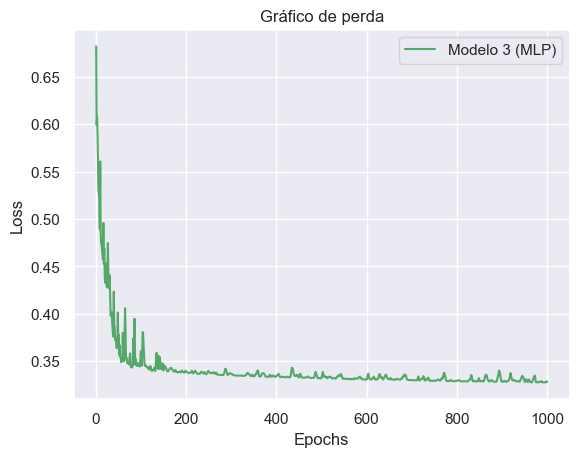

4178/4178 [==============================] - 9s 2ms/step
Matriz de Confusão - TREINO:
[[29389  9163]
 [10261 84865]]
Acurácia - TREINO: 0.8547
Recall - TREINO: 0.8921
Precisão - TREINO: 0.9026




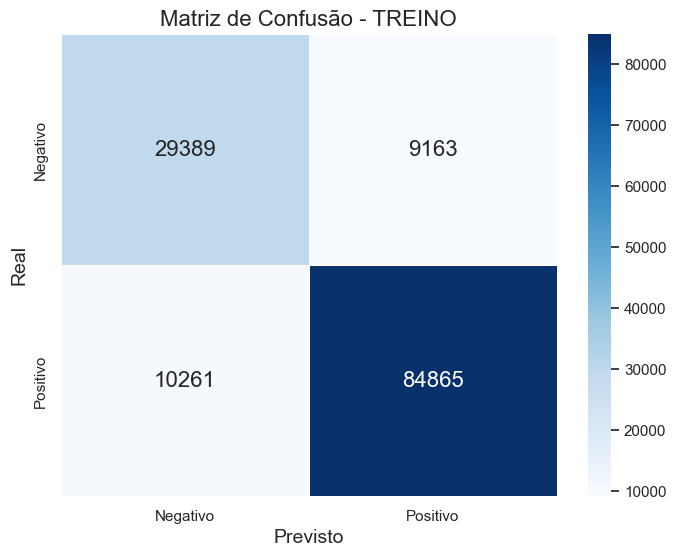

1671/1671 [==============================] - 4s 2ms/step
Matriz de Confusão - TESTE:
[[11877  3632]
 [ 4016 33946]]
Acurácia - TESTE: 0.8570
Recall - TESTE: 0.8942
Precisão - TESTE: 0.9033




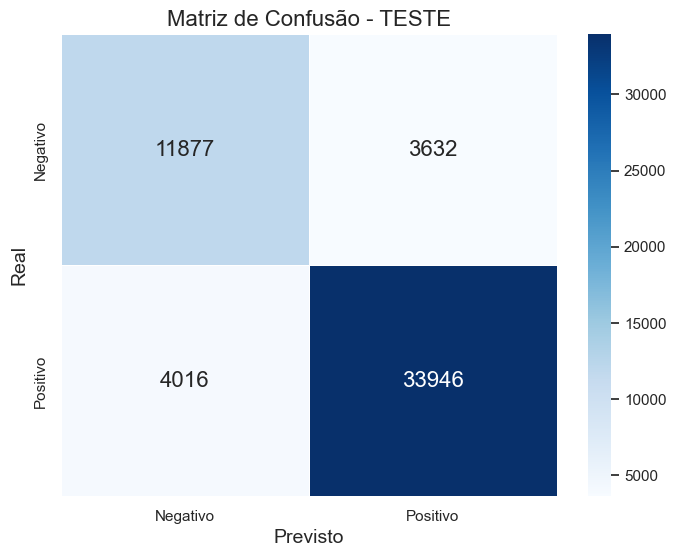

1114/1114 [==============================] - 2s 2ms/step
Matriz de Confusão - VALIDAÇÃO:
[[ 7752  2384]
 [ 2741 22771]]
Acurácia - VALIDAÇÃO: 0.8562
Recall - VALIDAÇÃO: 0.8926
Precisão - VALIDAÇÃO: 0.9052




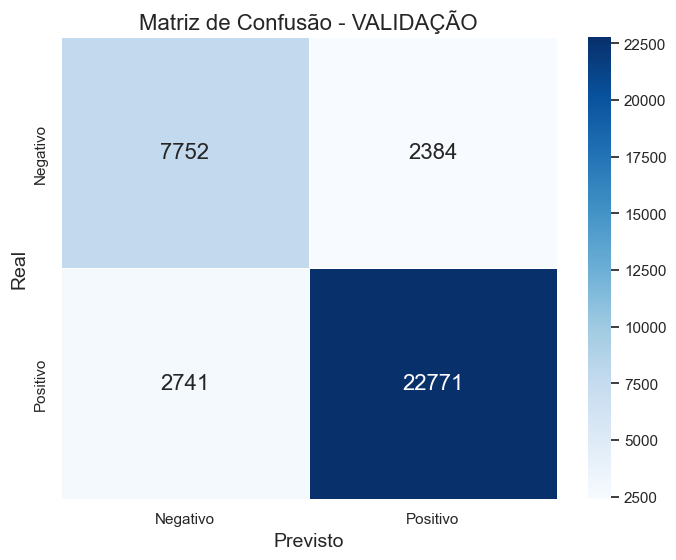

In [44]:
model3 = Sequential()

model3.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))


model3.compile(optimizer=tf.optimizers.Adamax(), loss='binary_crossentropy', metrics=['accuracy'])

history3 = model3.fit(
    X_train, 
    y_train, 
    epochs=1000, 
    batch_size=int(0.25 * len(X_train)), 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping_callback, lr_scheduler_callback],
    verbose=1
)

# Grafico do Loss
train_loss3 = history3.history['loss']
epochs = range(1, len(train_loss3) + 1)
plt.plot(epochs, train_loss3, 'g', label='Modelo 3 (MLP)')
plt.title('Gráfico de perda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

evaluate_model(model3, X_train, y_train, "Treino")

# Avaliação no conjunto de teste
evaluate_model(model3, X_test, y_test, "Teste")

# Avaliação no conjunto de validação
evaluate_model(model3, X_val, y_val, "Validação")

### Modelo 4: SVM

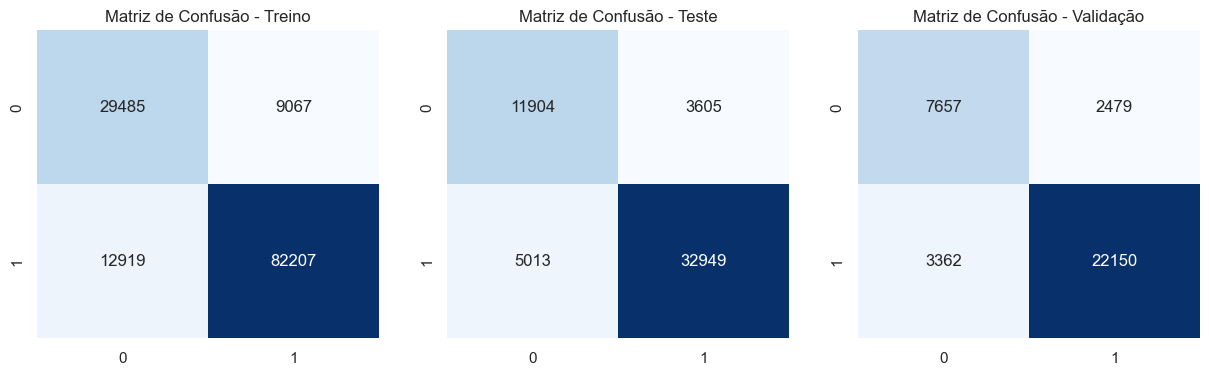

Acurácia - Treino: 0.8355, Teste: 0.8388, Validação: 0.8361
Precisão - Treino: 0.9007, Teste: 0.9014, Validação: 0.8993
Recall - Treino: 0.8642, Teste: 0.8679, Validação: 0.8682


In [43]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

# Criar e treinar o modelo SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)


# Previsões nos conjuntos de treino, teste e validação
svm_train_predictions = svm_model.predict(X_train)
svm_test_predictions = svm_model.predict(X_test)
svm_val_predictions = svm_model.predict(X_val)

# Métricas nos conjuntos de treino, teste e validação
accuracy_train = accuracy_score(y_train, svm_train_predictions)
accuracy_test = accuracy_score(y_test, svm_test_predictions)
accuracy_val = accuracy_score(y_val, svm_val_predictions)

precision_train = precision_score(y_train, svm_train_predictions)
precision_test = precision_score(y_test, svm_test_predictions)
precision_val = precision_score(y_val, svm_val_predictions)

recall_train = recall_score(y_train, svm_train_predictions)
recall_test = recall_score(y_test, svm_test_predictions)
recall_val = recall_score(y_val, svm_val_predictions)

# Matrizes de confusão
conf_matrix_train = confusion_matrix(y_train, svm_train_predictions)
conf_matrix_test = confusion_matrix(y_test, svm_test_predictions)
conf_matrix_val = confusion_matrix(y_val, svm_val_predictions)

# Plotar as matrizes de confusão
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Matriz de Confusão - Treino')

sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title('Matriz de Confusão - Teste')

sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[2])
axes[2].set_title('Matriz de Confusão - Validação')

plt.show()

# Imprimir métricas
print(f'Acurácia - Treino: {accuracy_train:.4f}, Teste: {accuracy_test:.4f}, Validação: {accuracy_val:.4f}')
print(f'Precisão - Treino: {precision_train:.4f}, Teste: {precision_test:.4f}, Validação: {precision_val:.4f}')
print(f'Recall - Treino: {recall_train:.4f}, Teste: {recall_test:.4f}, Validação: {recall_val:.4f}')

